 Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load & Prepare Data

In [19]:
df = pd.read_csv("../data/processed/scheduled_generation.csv", parse_dates=['Datetime']) ##here add your own path do not copy this one

# Rename column for convenience
df.rename(columns={'Scheduled_Generation_MW': 'power'}, inplace=True)

# Sort by datetime and set index
df.sort_values('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)

# Reindex to ensure continuous 15-min intervals 
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15T')
df = df.reindex(full_idx)
df.index.name = 'Datetime'

C:\Users\vishal kumar\AppData\Local\Temp\ipykernel_13928\4205053935.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15T')


Forecasting Function

In [20]:
def advanced_mean_forecast(df, forecast_year, forecast_month, day_window=3, interval_window=3):
    """
    Mean-based 15-min forecast using ±N days and ±N intervals around target date & time over past 4 years.
    
  
    """
    start_date = pd.Timestamp(f'{forecast_year}-{forecast_month:02d}-01 00:00:00')
    if forecast_month == 12:
        end_date = pd.Timestamp(f'{forecast_year + 1}-01-01 00:00:00') - pd.Timedelta(minutes=15)
    else:
        end_date = pd.Timestamp(f'{forecast_year}-{forecast_month + 1:02d}-01 00:00:00') - pd.Timedelta(minutes=15)

    forecast_dates = pd.date_range(start=start_date, end=end_date, freq='15T')
    predictions = []

    for current_time in forecast_dates:
        target_time = current_time.time()
        target_day = current_time.day
        target_month = current_time.month

        values = []

        for year in range(forecast_year - 4, forecast_year):  # Past 4 years
            base_date = pd.Timestamp(f"{year}-{target_month:02d}-{target_day:02d} {target_time}")
            for day_offset in range(-day_window, day_window + 1):
                try:
                    date_to_check = base_date + pd.Timedelta(days=day_offset)
                    for interval_offset in range(-interval_window, interval_window + 1):
                        time_to_check = date_to_check + pd.Timedelta(minutes=15 * interval_offset)
                        if time_to_check in df.index:
                            val = df.loc[time_to_check, 'power']
                            if not np.isnan(val):
                                values.append(val)
                except Exception:
                    continue

        if values:
            pred = np.mean(values)
            std_dev = np.std(values)
        else:
            pred = np.nan
            std_dev = np.nan

        predictions.append({
            'Datetime': current_time,
            'Predicted_Power': pred,
            'Std_Dev': std_dev
        })

    pred_df = pd.DataFrame(predictions)
    return pred_df


Run Forecast

In [21]:
forecast_year = 2026
forecast_month = 1

forecast_df = advanced_mean_forecast(
    df,
    forecast_year=forecast_year,
    forecast_month=forecast_month,
    day_window=3,
    interval_window=3
)

C:\Users\vishal kumar\AppData\Local\Temp\ipykernel_13928\2900887115.py:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_dates = pd.date_range(start=start_date, end=end_date, freq='15T')


In [ ]:
# output_path = "give your saving path"_{forecast_year}_{forecast_month:02d}.csv"      give your own path for saving
forecast_df.to_csv(output_path, index=False)
print(f"Forecast saved to: {output_path}")


Display Sample Predictions

In [23]:
print(forecast_df.head(100).to_string(index=False))

           Datetime  Predicted_Power    Std_Dev
2026-01-01 00:00:00       118.326531 171.790220
2026-01-01 00:15:00        99.632653 157.600894
2026-01-01 00:30:00        85.496599 140.148239
2026-01-01 00:45:00        79.115646 136.066586
2026-01-01 01:00:00        83.074830 145.672127
2026-01-01 01:15:00       101.197279 166.320347
2026-01-01 01:30:00       115.789116 177.259533
2026-01-01 01:45:00       115.619048 171.406678
2026-01-01 02:00:00       114.972789 171.704855
2026-01-01 02:15:00       108.789116 172.667753
2026-01-01 02:30:00        90.972789 157.737013
2026-01-01 02:45:00        73.156463 138.970985
2026-01-01 03:00:00        55.340136 114.499175
2026-01-01 03:15:00        34.659864  70.256043
2026-01-01 03:30:00        28.414966  65.388722
2026-01-01 03:45:00        28.360544  65.399031
2026-01-01 04:00:00        28.306122  65.409294
2026-01-01 04:15:00        25.122449  53.685263
2026-01-01 04:30:00        21.938776  38.282733
2026-01-01 04:45:00        18.755102   5

Visualization: Full Month Overview (Daily Aggregates)

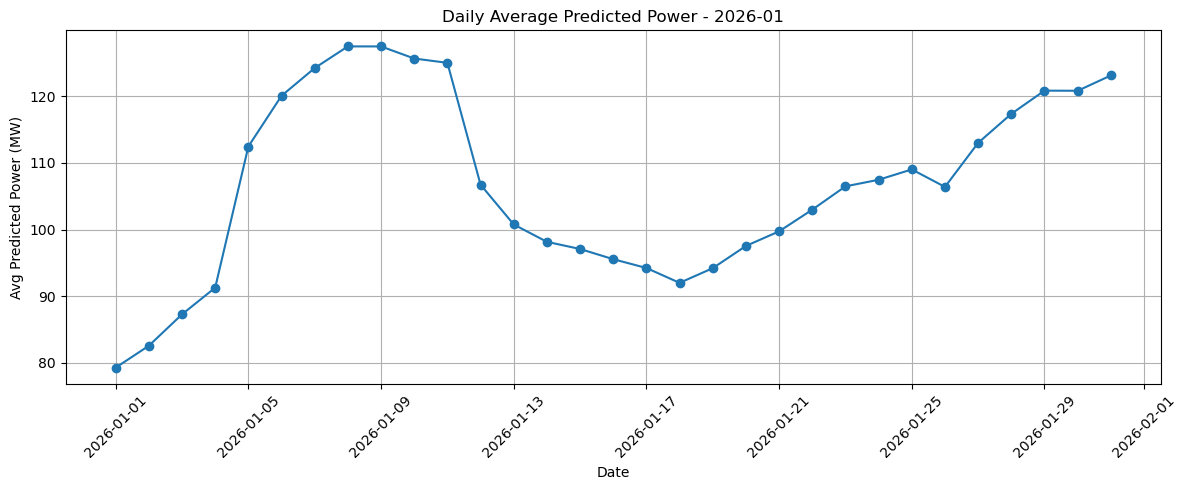

In [24]:
forecast_df['Date'] = forecast_df['Datetime'].dt.date
daily_agg = forecast_df.groupby('Date')['Predicted_Power'].mean()

plt.figure(figsize=(12, 5))
plt.plot(daily_agg.index, daily_agg.values, marker='o')
plt.title(f"Daily Average Predicted Power - {forecast_year}-{forecast_month:02d}")
plt.xlabel("Date")
plt.ylabel("Avg Predicted Power (MW)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Visualization: Sample Day with Confidence Interval

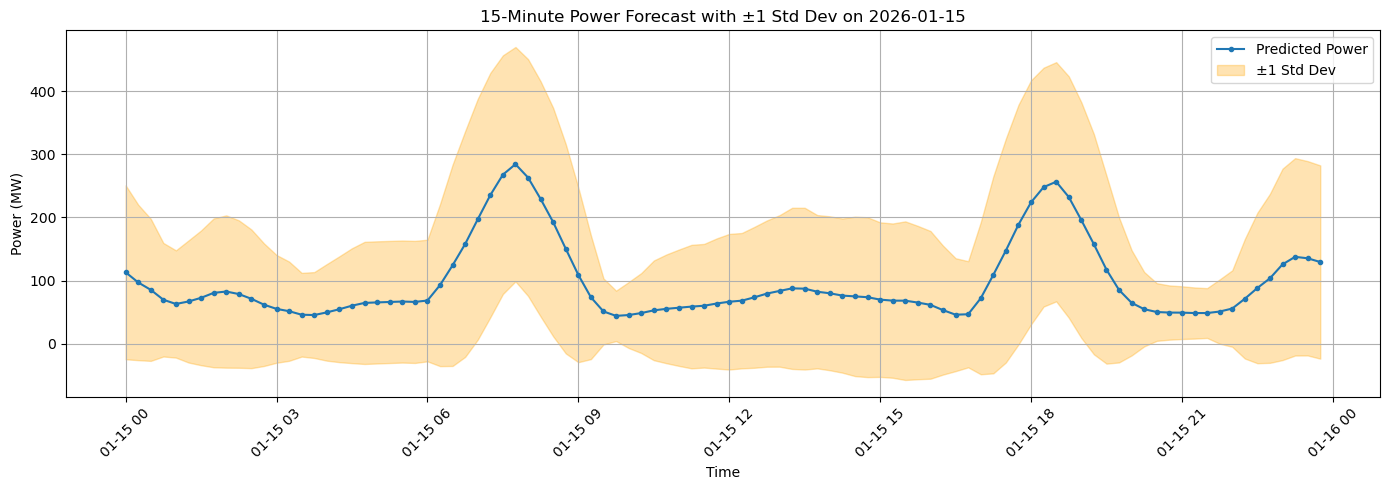

In [25]:
sample_day = f"{forecast_year}-{forecast_month:02d}-15"
plot_df = forecast_df[forecast_df['Datetime'].dt.strftime('%Y-%m-%d') == sample_day]

plt.figure(figsize=(14, 5))
plt.plot(plot_df['Datetime'], plot_df['Predicted_Power'], label='Predicted Power', marker='.')
plt.fill_between(
    plot_df['Datetime'],
    plot_df['Predicted_Power'] - plot_df['Std_Dev'],
    plot_df['Predicted_Power'] + plot_df['Std_Dev'],
    color='orange',
    alpha=0.3,
    label='±1 Std Dev'
)
plt.title(f"15-Minute Power Forecast with ±1 Std Dev on {sample_day}")
plt.xlabel("Time")
plt.ylabel("Power (MW)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
import seaborn as sns

def plot_power_heatmap(df, year, month):
    df_month = df[(df.index.year == year) & (df.index.month == month)]
    print(f"Data points for {year}-{month:02d}: {len(df_month)}")
    if df_month.empty:
        print("No data available for this month and year.")
        return
    df_month['Day'] = df_month.index.day
    df_month['Hour'] = df_month.index.hour + df_month.index.minute/60

    pivot = df_month.pivot_table(index='Hour', columns='Day', values='power', aggfunc='mean')

    plt.figure(figsize=(15,8))
    sns.heatmap(pivot, cmap='YlGnBu', cbar_kws={'label': 'Power (MW)'})
    plt.title(f"Heatmap of Average Power (MW) by Hour and Day - {year}-{month:02d}")
    plt.xlabel("Day of Month")
    plt.ylabel("Hour of Day")
    plt.tight_layout()
    plt.show()


In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np

def plot_day_comparison(df, forecast_df, forecast_year, forecast_month, day, day_window=0):
    """
    Plot 15-min predicted vs actual power for a specific day,
    including same day (±day_window) from last 4 years.

  ay_window : int - days before/after to include from historical years (default 0 for exact day)
    """
    plt.figure(figsize=(15,6))
    
    target_day_str = f"{forecast_year}-{forecast_month:02d}-{day:02d}"
    forecast_day_df = forecast_df[forecast_df['Datetime'].dt.strftime('%Y-%m-%d') == target_day_str]

    if forecast_day_df.empty:
        print(f"No forecast data available for {target_day_str}")
        return

    # Convert forecast times to datetime on dummy date for plotting
    forecast_times = [datetime.datetime.combine(datetime.date(1900,1,1), t) for t in forecast_day_df['Datetime'].dt.time]
    plt.plot(forecast_times, forecast_day_df['Predicted_Power'],
             label=f'Forecast {forecast_year}', linewidth=3, color='red', marker='o')

    colors = ['blue', 'green', 'orange', 'purple']

    for i, year in enumerate(range(forecast_year - 4, forecast_year)):
        day_values = []
        time_values = []

        for day_offset in range(-day_window, day_window + 1):
            hist_date = pd.Timestamp(f"{year}-{forecast_month:02d}-{day:02d}") + pd.Timedelta(days=day_offset)
            mask = (df.index.date == hist_date.date())
            hist_day_data = df.loc[mask, 'power']

            if hist_day_data.empty:
                continue

            day_values.append(hist_day_data.values)
            time_values.append(hist_day_data.index.time)

        if day_values:
            all_values = np.concatenate(day_values)
            all_times = np.concatenate(time_values)

            unique_times = sorted(set(all_times))
            avg_values = []
            for t in unique_times:
                vals = [all_values[j] for j in range(len(all_times)) if all_times[j] == t]
                avg_values.append(np.mean(vals))

            hist_times = [datetime.datetime.combine(datetime.date(1900,1,1), t) for t in unique_times]

            plt.plot(hist_times, avg_values,
                     label=f'Historical {year} (±{day_window}d)', color=colors[i], alpha=0.7)

    plt.title(f"Forecast vs Historical Power on {target_day_str}")
    plt.xlabel("Time of Day")
    plt.ylabel("Power (MW)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.tight_layout()
    plt.show()


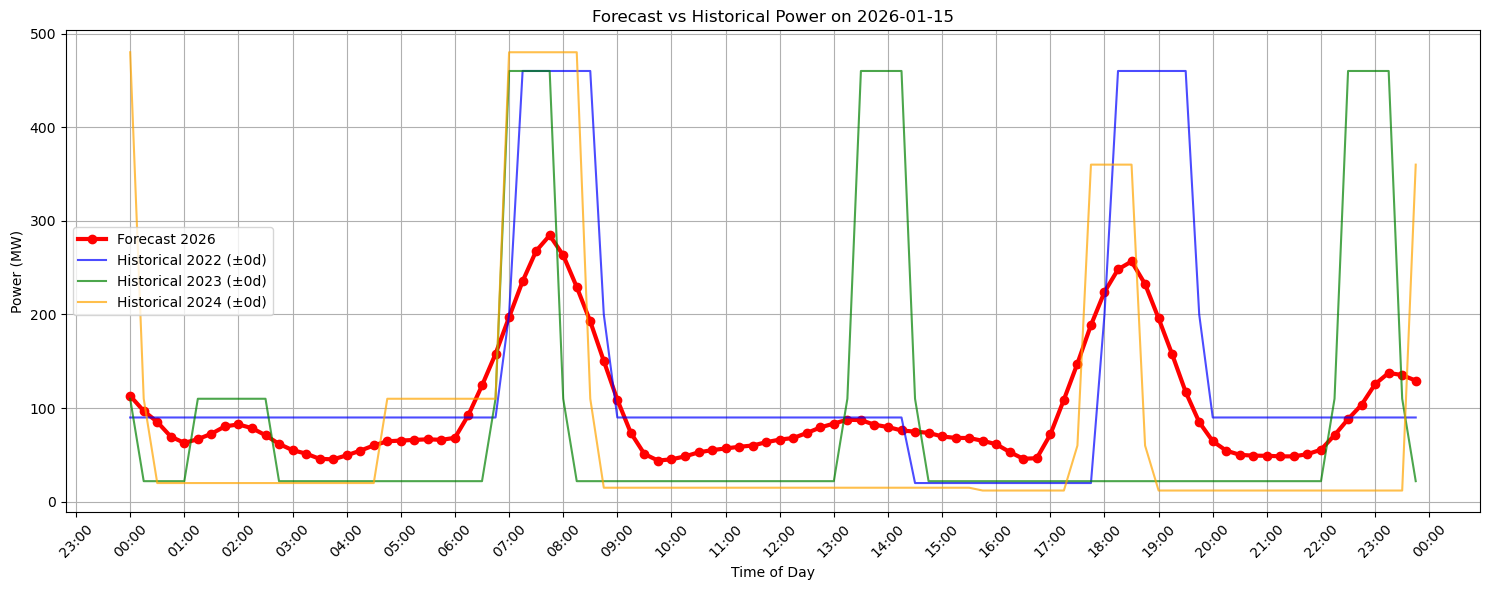

In [34]:
plot_day_comparison(df, forecast_df, forecast_year=2026, forecast_month=1, day=15, day_window=0)


HEATMAP